In [3]:
# =============================================================================
# STEP 1: IMPORT ALL NECESSARY LIBRARIES
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind, f_oneway
import warnings
warnings.filterwarnings('ignore')

# Statistical and ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.feature_selection import SelectKBest, f_classif

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
print("All libraries imported successfully!")

All libraries imported successfully!


In [4]:
# =============================================================================
# STEP 2: DATA EXPLORATION
# =============================================================================
print("=" * 70)
print("STEP 2: DATA EXPLORATION")
print("=" * 70)

# Load the dataset
df = pd.read_csv('diabetes_prediction_dataset.csv')

# Basic dataset information
print(" DATASET OVERVIEW:")
print(f"Dataset shape: {df.shape}")
print(f"Number of features: {df.shape[1]}")
print(f"Number of records: {df.shape[0]}")

print("\n FIRST 5 ROWS:")
print(df.head())

print("\n DATASET INFORMATION:")
print(df.info())

print("\n MISSING VALUES:")
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0] if missing_data.sum() > 0 else "No missing values!")

print("\n STATISTICAL SUMMARY:")
print(df.describe())

STEP 2: DATA EXPLORATION
 DATASET OVERVIEW:
Dataset shape: (100000, 9)
Number of features: 9
Number of records: 100000

 FIRST 5 ROWS:
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  

 DATASET INFORMATION:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column       

In [6]:
# =============================================================================
# STEP 3: DATA CLEANING AND PREPARATION
# =============================================================================
print("=" * 70)
print("STEP 3: DATA CLEANING AND PREPARATION")
print("=" + "=" * 69)

# Create a clean copy
df_clean = df.copy()

print(" DATA TRANSFORMATIONS:")

# 3.1 Handle gender column
print("Gender distribution before cleaning:")
print(df_clean['gender'].value_counts())
df_clean['gender'] = df_clean['gender'].map({'Male': 1, 'Female': 0, 'Other': 2})
df_clean['gender'] = df_clean['gender'].fillna(0)
print("Gender distribution after cleaning:")
print(df_clean['gender'].value_counts())

# 3.2 Handle smoking_history
print("\nSmoking history before cleaning:")
print(df_clean['smoking_history'].value_counts())
smoking_mapping = {
    'never': 0,
    'former': 1,
    'current': 2,
    'ever': 3,
    'not current': 4,
    'No Info': 5
}
df_clean['smoking_history'] = df_clean['smoking_history'].map(smoking_mapping)
print("Smoking history after cleaning:")
print(df_clean['smoking_history'].value_counts())

# 3.3 Check for outliers and anomalies
print(f"\n DATA QUALITY CHECKS:")
print(f"Age range: {df_clean['age'].min():.2f} - {df_clean['age'].max():.2f}")
print(f"Records with age < 1: {len(df_clean[df_clean['age'] < 1])}")
print(f"Records with age > 100: {len(df_clean[df_clean['age'] > 100])}")
print(f"BMI range: {df_clean['bmi'].min():.2f} - {df_clean['bmi'].max():.2f}")

# 3.4 Create new features if needed
# Age groups
df_clean['age_group'] = pd.cut(df_clean['age'],
                              bins=[0, 18, 35, 50, 65, 100],
                              labels=['Child', 'Young Adult', 'Adult', 'Middle Aged', 'Senior'])

# BMI categories
df_clean['bmi_category'] = pd.cut(df_clean['bmi'],
                                bins=[0, 18.5, 25, 30, 100],
                                labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

print("\n DATA CLEANING COMPLETED!")
print(f"Final dataset shape: {df_clean.shape}")

STEP 3: DATA CLEANING AND PREPARATION
 DATA TRANSFORMATIONS:
Gender distribution before cleaning:
gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64
Gender distribution after cleaning:
gender
0    58552
1    41430
2       18
Name: count, dtype: int64

Smoking history before cleaning:
smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64
Smoking history after cleaning:
smoking_history
5    35816
0    35095
1     9352
2     9286
4     6447
3     4004
Name: count, dtype: int64

 DATA QUALITY CHECKS:
Age range: 0.08 - 80.00
Records with age < 1: 911
Records with age > 100: 0
BMI range: 10.01 - 95.69

 DATA CLEANING COMPLETED!
Final dataset shape: (100000, 11)


STEP 4: DATA VISUALIZATION


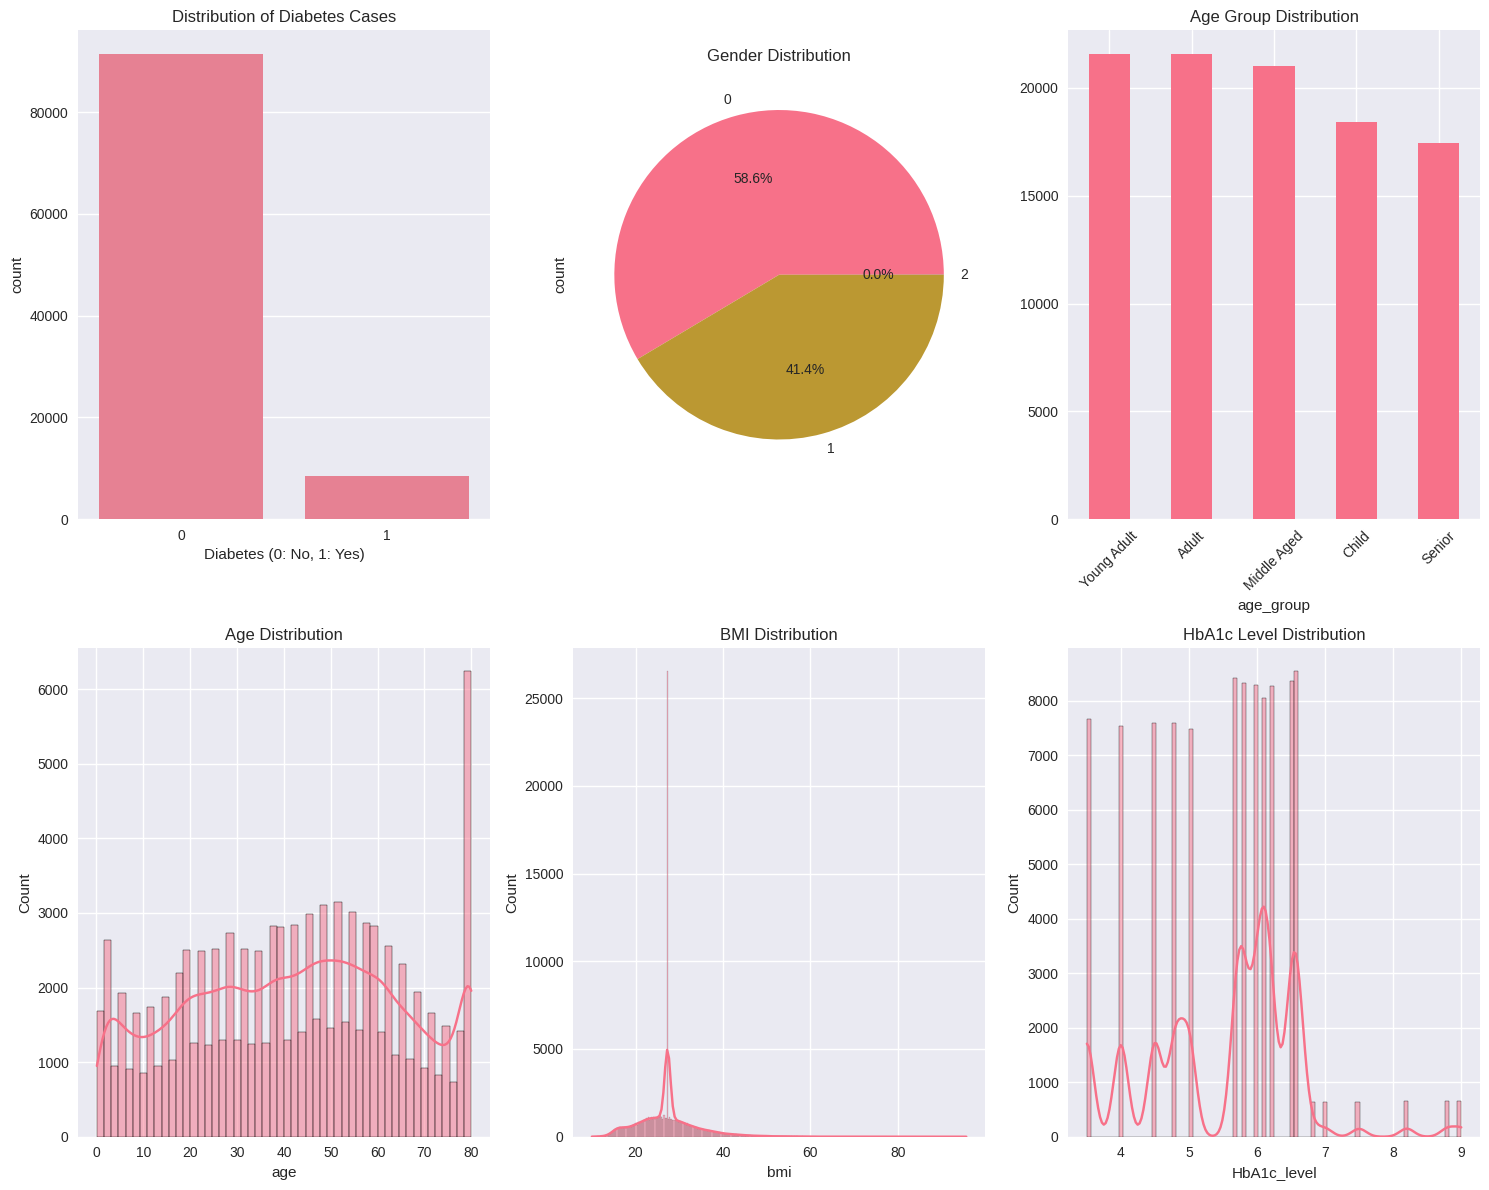

In [7]:
# =============================================================================
# STEP 4: VISUALIZE KEY VARIABLES AND RELATIONSHIPS
# =============================================================================
print("=" * 70)
print("STEP 4: DATA VISUALIZATION")
print("=" + "=" * 69)

# 4.1 Target Variable Distribution
plt.figure(figsize=(15, 12))

plt.subplot(2, 3, 1)
sns.countplot(x='diabetes', data=df_clean)
plt.title('Distribution of Diabetes Cases')
plt.xlabel('Diabetes (0: No, 1: Yes)')

# 4.2 Categorical Variables
plt.subplot(2, 3, 2)
df_clean['gender'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Gender Distribution')

plt.subplot(2, 3, 3)
df_clean['age_group'].value_counts().plot(kind='bar')
plt.title('Age Group Distribution')
plt.xticks(rotation=45)

# 4.3 Numerical Variables Distribution
plt.subplot(2, 3, 4)
sns.histplot(df_clean['age'], kde=True)
plt.title('Age Distribution')

plt.subplot(2, 3, 5)
sns.histplot(df_clean['bmi'], kde=True)
plt.title('BMI Distribution')

plt.subplot(2, 3, 6)
sns.histplot(df_clean['HbA1c_level'], kde=True)
plt.title('HbA1c Level Distribution')

plt.tight_layout()
plt.show()

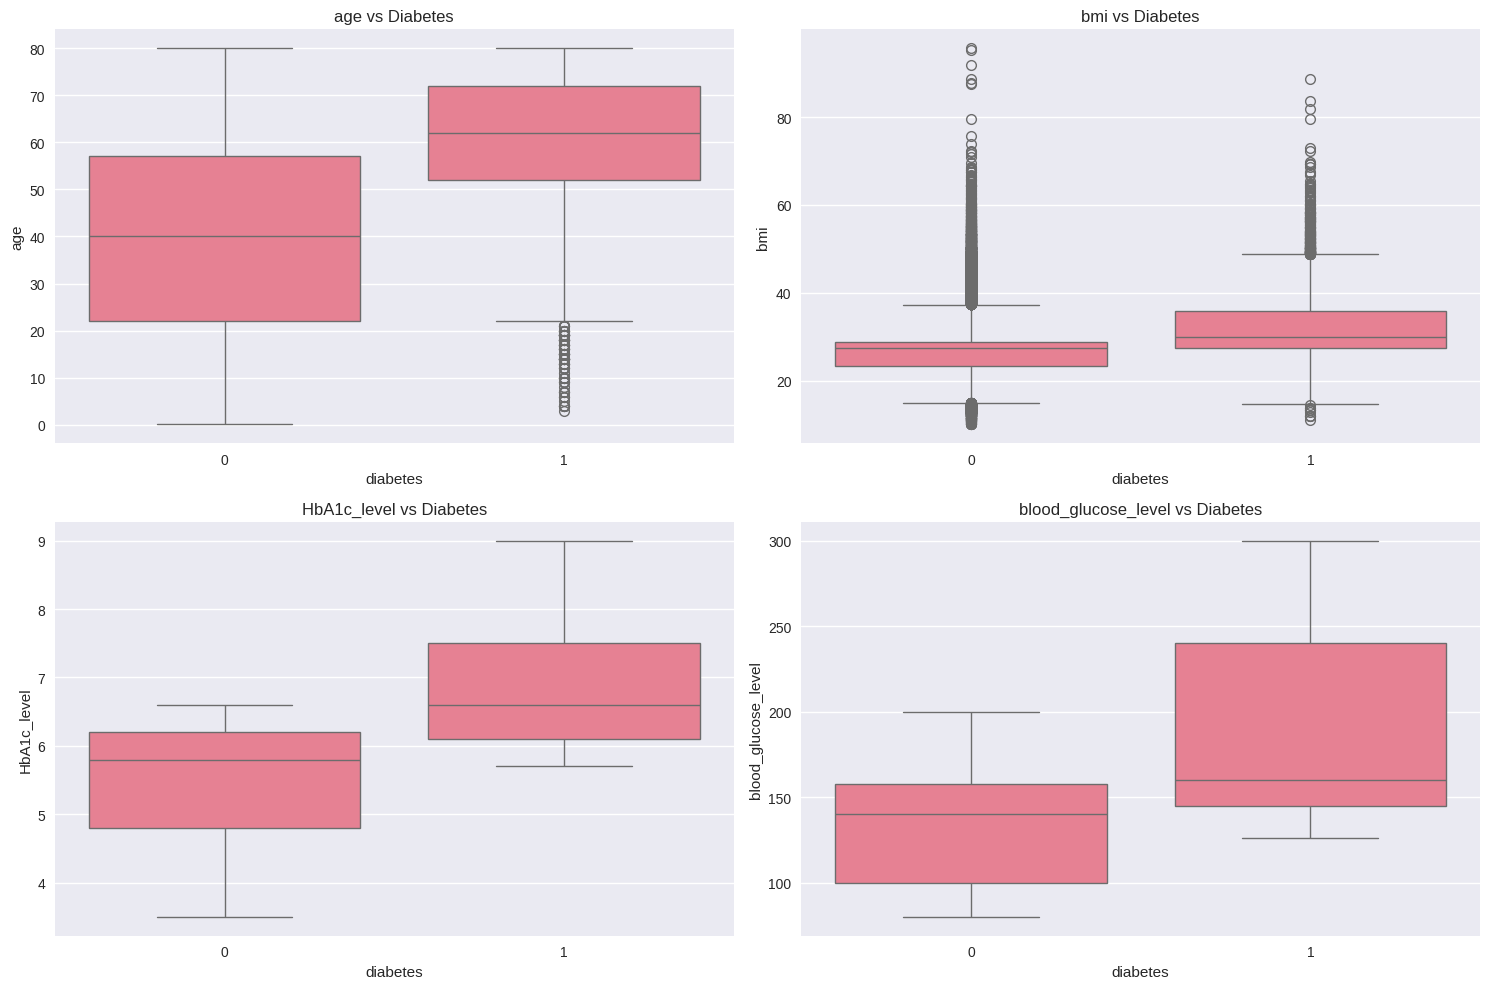

In [8]:
# 4.4 Relationships with Target Variable
plt.figure(figsize=(15, 10))

# Numerical features vs diabetes
numerical_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='diabetes', y=feature, data=df_clean)
    plt.title(f'{feature} vs Diabetes')

plt.tight_layout()
plt.show()

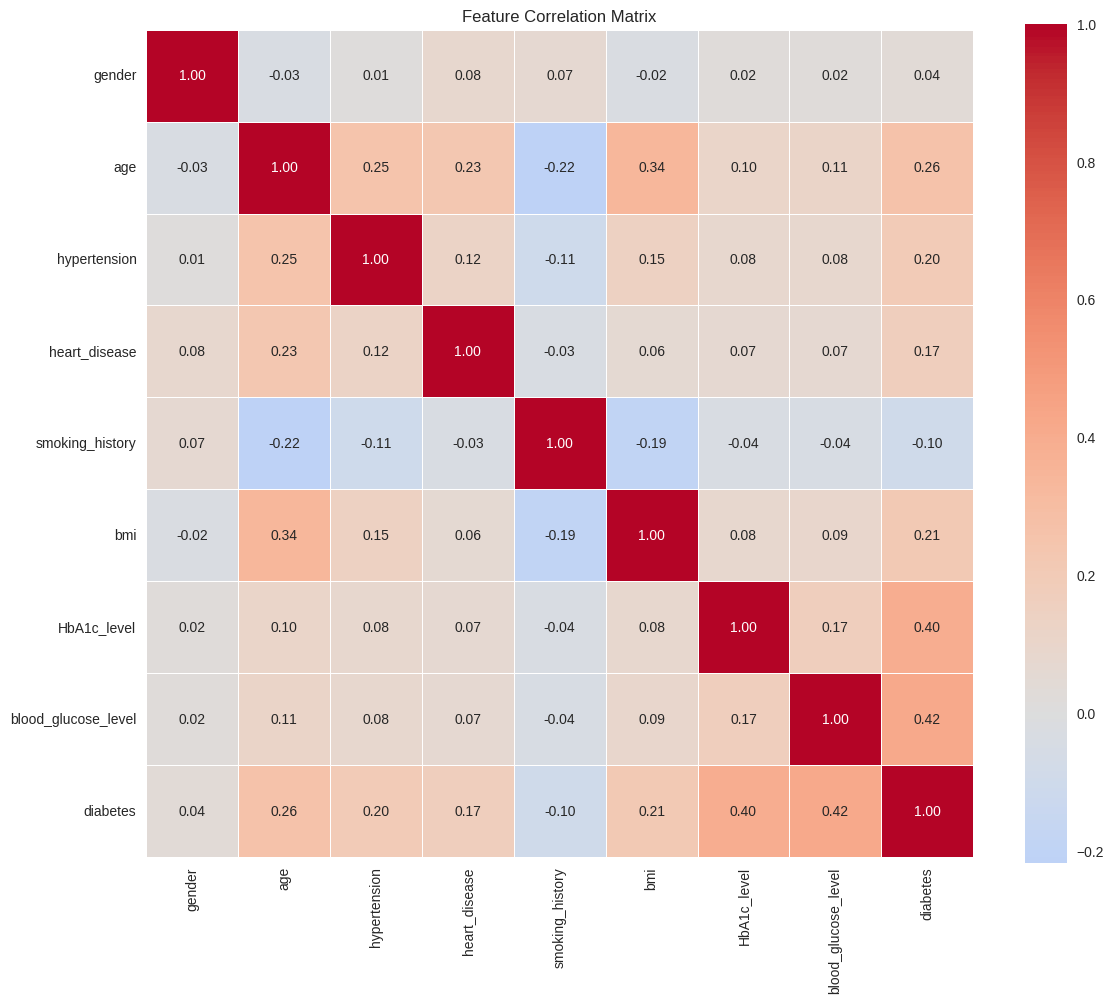

🔗 TOP CORRELATIONS WITH DIABETES:
diabetes               1.000000
blood_glucose_level    0.419558
HbA1c_level            0.400660
age                    0.258008
bmi                    0.214357
hypertension           0.197823
heart_disease          0.171727
gender                 0.037411
smoking_history       -0.095997
Name: diabetes, dtype: float64


In [9]:
# 4.5 Correlation Heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = df_clean.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

print("🔗 TOP CORRELATIONS WITH DIABETES:")
diabetes_correlations = correlation_matrix['diabetes'].sort_values(ascending=False)
print(diabetes_correlations)

In [10]:
# =============================================================================
# STEP 5: STATISTICAL TESTS
# =============================================================================
print("=" * 70)
print("STEP 5: STATISTICAL TESTS")
print("=" + "=" * 69)

# 5.1 T-Tests for Numerical Variables
print("T-TESTS (Diabetes vs Non-Diabetes Groups):")
print("-" * 50)

for feature in numerical_features:
    group1 = df_clean[df_clean['diabetes'] == 0][feature]  # Non-diabetic
    group2 = df_clean[df_clean['diabetes'] == 1][feature]  # Diabetic

    t_stat, p_value = ttest_ind(group1, group2, equal_var=False)

    print(f"{feature:20} | t-statistic: {t_stat:8.2f} | p-value: {p_value:.6f} | {'***' if p_value < 0.001 else '** ' if p_value < 0.01 else '*  ' if p_value < 0.05 else 'NS '}")

STEP 5: STATISTICAL TESTS
T-TESTS (Diabetes vs Non-Diabetes Groups):
--------------------------------------------------
age                  | t-statistic:  -119.59 | p-value: 0.000000 | ***
bmi                  | t-statistic:   -60.27 | p-value: 0.000000 | ***
HbA1c_level          | t-statistic:  -127.01 | p-value: 0.000000 | ***
blood_glucose_level  | t-statistic:   -94.79 | p-value: 0.000000 | ***


In [11]:
# 5.2 Chi-Square Tests for Categorical Variables
print("\n CHI-SQUARE TESTS:")
print("-" * 50)

categorical_features = ['gender', 'hypertension', 'heart_disease', 'age_group', 'bmi_category']

for feature in categorical_features:
    contingency_table = pd.crosstab(df_clean[feature], df_clean['diabetes'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    print(f"{feature:20} | Chi2: {chi2:8.2f} | p-value: {p_value:.6f} | {'***' if p_value < 0.001 else '** ' if p_value < 0.01 else '*  ' if p_value < 0.05 else 'NS '}")


 CHI-SQUARE TESTS:
--------------------------------------------------
gender               | Chi2:   143.22 | p-value: 0.000000 | ***
hypertension         | Chi2:  3910.71 | p-value: 0.000000 | ***
heart_disease        | Chi2:  2945.85 | p-value: 0.000000 | ***
age_group            | Chi2:  7117.65 | p-value: 0.000000 | ***
bmi_category         | Chi2:  4088.90 | p-value: 0.000000 | ***


In [12]:
# 5.3 ANOVA Test for Multiple Groups
print("\n ANOVA TESTS:")
print("-" * 50)

# ANOVA for smoking history groups
smoking_groups = [df_clean[df_clean['smoking_history'] == i]['blood_glucose_level']
                 for i in df_clean['smoking_history'].unique() if len(df_clean[df_clean['smoking_history'] == i]) > 30]

f_stat, p_value = f_oneway(*smoking_groups)
print(f"Smoking History vs Blood Glucose | F-statistic: {f_stat:6.2f} | p-value: {p_value:.6f} | {'***' if p_value < 0.001 else '** ' if p_value < 0.01 else '*  ' if p_value < 0.05 else 'NS '}")

# ANOVA for age groups
age_groups = [df_clean[df_clean['age_group'] == group]['HbA1c_level']
             for group in df_clean['age_group'].unique()]

f_stat, p_value = f_oneway(*age_groups)
print(f"Age Group vs HbA1c Level     | F-statistic: {f_stat:6.2f} | p-value: {p_value:.6f} | {'***' if p_value < 0.001 else '** ' if p_value < 0.01 else '*  ' if p_value < 0.05 else 'NS '}")


 ANOVA TESTS:
--------------------------------------------------
Smoking History vs Blood Glucose | F-statistic:  71.46 | p-value: 0.000000 | ***
Age Group vs HbA1c Level     | F-statistic: 285.25 | p-value: 0.000000 | ***


In [13]:
# 5.4 Logistic Regression for Feature Significance
print("\n LOGISTIC REGRESSION COEFFICIENTS:")
print("-" * 50)

from sklearn.linear_model import LogisticRegression

# Prepare data for logistic regression
X_stats = df_clean[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'gender', 'hypertension', 'heart_disease', 'smoking_history']]
y_stats = df_clean['diabetes']

# Scale numerical features
scaler_stats = StandardScaler()
X_stats_scaled = scaler_stats.fit_transform(X_stats)

# Fit logistic regression
log_reg_stats = LogisticRegression(random_state=42, max_iter=1000)
log_reg_stats.fit(X_stats_scaled, y_stats)

# Display coefficients
feature_names = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'gender', 'hypertension', 'heart_disease', 'smoking_history']
coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': log_reg_stats.coef_[0],
    'Abs_Coefficient': np.abs(log_reg_stats.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print(coefficients.to_string(index=False))


 LOGISTIC REGRESSION COEFFICIENTS:
--------------------------------------------------
            Feature  Coefficient  Abs_Coefficient
        HbA1c_level     2.500967         2.500967
blood_glucose_level     1.357710         1.357710
                age     1.036081         1.036081
                bmi     0.594508         0.594508
    smoking_history    -0.212686         0.212686
       hypertension     0.199244         0.199244
      heart_disease     0.147724         0.147724
             gender     0.144968         0.144968


In [14]:
# =============================================================================
# STEP 6: PREDICTIVE MODELING
# =============================================================================
print("=" * 70)
print("STEP 6: PREDICTIVE MODELING")
print("=" + "=" * 69)

# 6.1 Prepare Data for Machine Learning
print(" PREPARING DATA FOR ML...")

# Select features for modeling
features_for_ml = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'gender',
                   'hypertension', 'heart_disease', 'smoking_history']

X = df_clean[features_for_ml]
y = df_clean['diabetes']

print(f"Feature matrix shape: {X.shape}")
print(f"Target variable distribution:\n{y.value_counts()}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(" Data preparation completed!")

STEP 6: PREDICTIVE MODELING
 PREPARING DATA FOR ML...
Feature matrix shape: (100000, 8)
Target variable distribution:
diabetes
0    91500
1     8500
Name: count, dtype: int64
Training set: (80000, 8), Testing set: (20000, 8)
 Data preparation completed!


MODEL 1: LOGISTIC REGRESSION
Training Logistic Regression...
 Training completed!
 Accuracy: 0.9601
 Cross-validation Scores: [0.96125 0.96065 0.96025 0.9595  0.9599 ]
 CV Mean: 0.9603 (+/- 0.0012)

 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18300
           1       0.86      0.64      0.73      1700

    accuracy                           0.96     20000
   macro avg       0.91      0.81      0.85     20000
weighted avg       0.96      0.96      0.96     20000



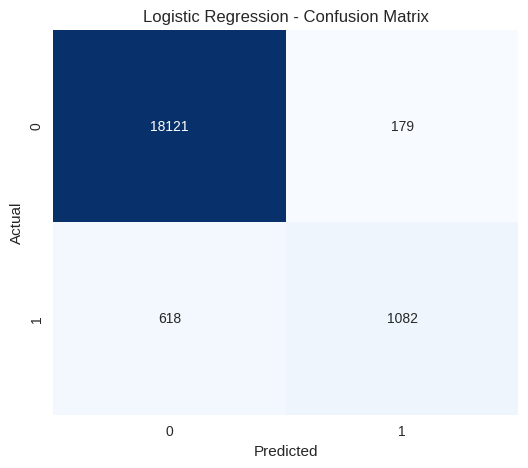

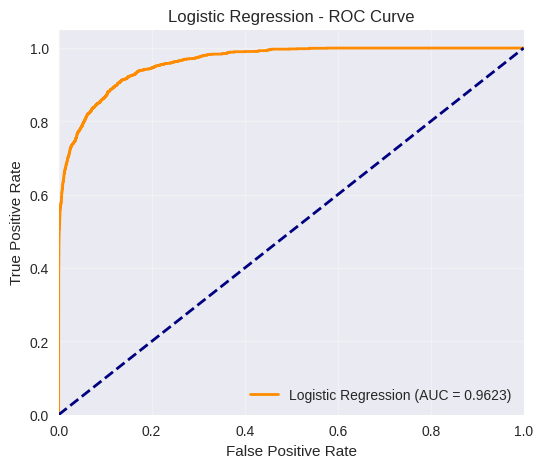

 Logistic Regression Coefficients:
            Feature  Coefficient
        HbA1c_level     2.496874
blood_glucose_level     1.364285
                age     1.025973
                bmi     0.598539
    smoking_history    -0.215573
       hypertension     0.204641
             gender     0.154544
      heart_disease     0.150407


In [15]:
# =============================================================================
# MODEL 1: LOGISTIC REGRESSION
# =============================================================================
print("=" * 60)
print("MODEL 1: LOGISTIC REGRESSION")
print("=" * 60)

# Initialize Logistic Regression
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# Train the model
print("Training Logistic Regression...")
log_reg.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lr = log_reg.predict(X_test_scaled)
y_pred_proba_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
cv_scores_lr = cross_val_score(log_reg, scaler.fit_transform(X), y, cv=5, scoring='accuracy')

print(f" Training completed!")
print(f" Accuracy: {accuracy_lr:.4f}")
print(f" Cross-validation Scores: {cv_scores_lr}")
print(f" CV Mean: {cv_scores_lr.mean():.4f} (+/- {cv_scores_lr.std() * 2:.4f})")

# Classification report
print("\n Classification Report:")
print(classification_report(y_test, y_pred_lr))

# Confusion Matrix
plt.figure(figsize=(6, 5))
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Logistic Regression - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(6, 5))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression - ROC Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(" Logistic Regression Coefficients:")
coefficients_lr = pd.DataFrame({
    'Feature': features_for_ml,
    'Coefficient': log_reg.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)
print(coefficients_lr.to_string(index=False))

MODEL 2: DECISION TREE
Training Decision Tree...
 Training completed!
 Accuracy: 0.9516
 Cross-validation Scores: [0.95495 0.95035 0.94865 0.95275 0.95285]
 CV Mean: 0.9519 (+/- 0.0044)

 Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     18300
           1       0.71      0.74      0.72      1700

    accuracy                           0.95     20000
   macro avg       0.84      0.85      0.85     20000
weighted avg       0.95      0.95      0.95     20000



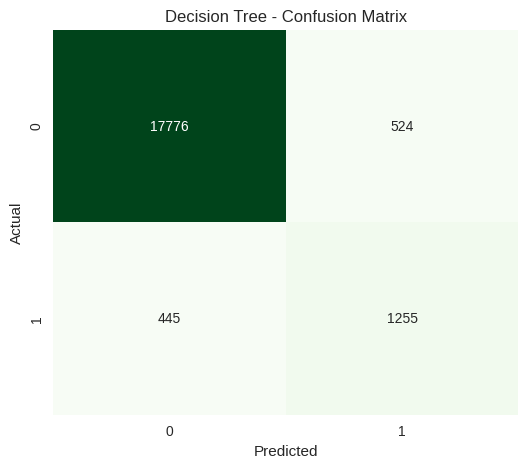

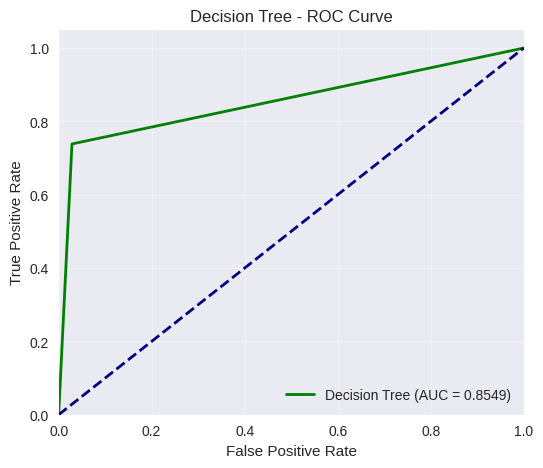

 Decision Tree Feature Importance:
            Feature  Importance
        HbA1c_level    0.489503
blood_glucose_level    0.270689
                bmi    0.123101
                age    0.065486
    smoking_history    0.028910
             gender    0.011451
       hypertension    0.006477
      heart_disease    0.004383


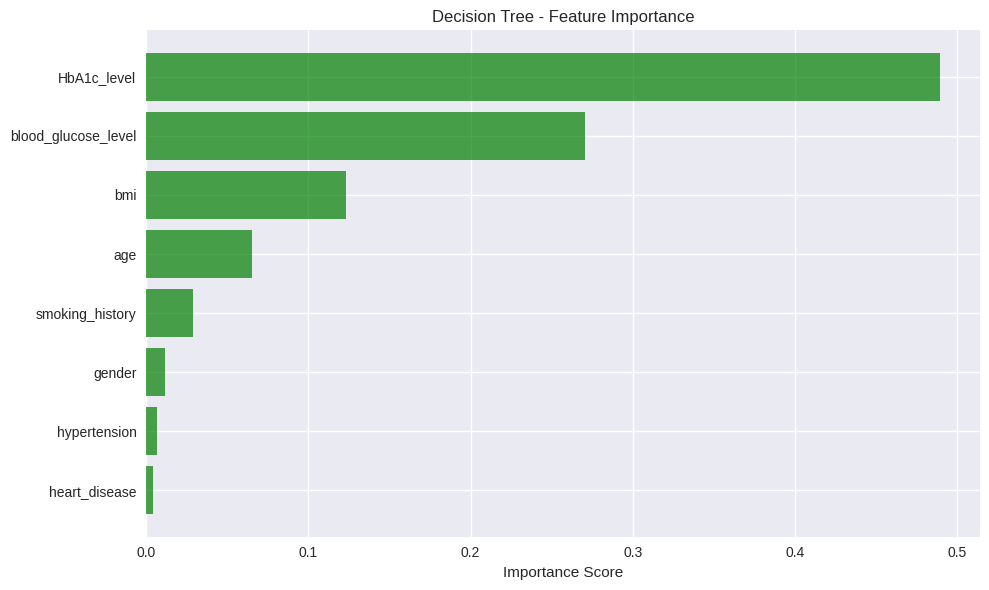

In [16]:
# =============================================================================
# MODEL 2: DECISION TREE
# =============================================================================
print("=" * 60)
print("MODEL 2: DECISION TREE")
print("=" * 60)

# Initialize Decision Tree
dt = DecisionTreeClassifier(random_state=42)

# Train the model
print("Training Decision Tree...")
dt.fit(X_train, y_train)

# Make predictions
y_pred_dt = dt.predict(X_test)
y_pred_proba_dt = dt.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy_dt = accuracy_score(y_test, y_pred_dt)
cv_scores_dt = cross_val_score(dt, X, y, cv=5, scoring='accuracy')

print(f" Training completed!")
print(f" Accuracy: {accuracy_dt:.4f}")
print(f" Cross-validation Scores: {cv_scores_dt}")
print(f" CV Mean: {cv_scores_dt.mean():.4f} (+/- {cv_scores_dt.std() * 2:.4f})")

# Classification report
print("\n Classification Report:")
print(classification_report(y_test, y_pred_dt))

# Confusion Matrix
plt.figure(figsize=(6, 5))
cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Decision Tree - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.figure(figsize=(6, 5))
plt.plot(fpr_dt, tpr_dt, color='green', lw=2, label=f'Decision Tree (AUC = {roc_auc_dt:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree - ROC Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Feature Importance
feature_importance_dt = pd.DataFrame({
    'Feature': features_for_ml,
    'Importance': dt.feature_importances_
}).sort_values('Importance', ascending=False)

print(" Decision Tree Feature Importance:")
print(feature_importance_dt.to_string(index=False))

# Plot Feature Importance
plt.figure(figsize=(10, 6))
feature_importance_dt_sorted = feature_importance_dt.sort_values('Importance', ascending=True)
plt.barh(feature_importance_dt_sorted['Feature'], feature_importance_dt_sorted['Importance'], color='green', alpha=0.7)
plt.title('Decision Tree - Feature Importance')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

MODEL 3: RANDOM FOREST
Training Random Forest...
 Training completed!
 Accuracy: 0.9707
 Cross-validation Scores: [0.9703  0.9708  0.96805 0.9703  0.97085]
 CV Mean: 0.9701 (+/- 0.0021)

 Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18300
           1       0.95      0.69      0.80      1700

    accuracy                           0.97     20000
   macro avg       0.96      0.84      0.89     20000
weighted avg       0.97      0.97      0.97     20000



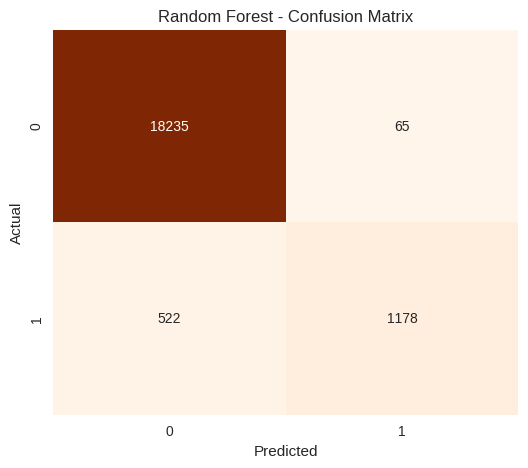

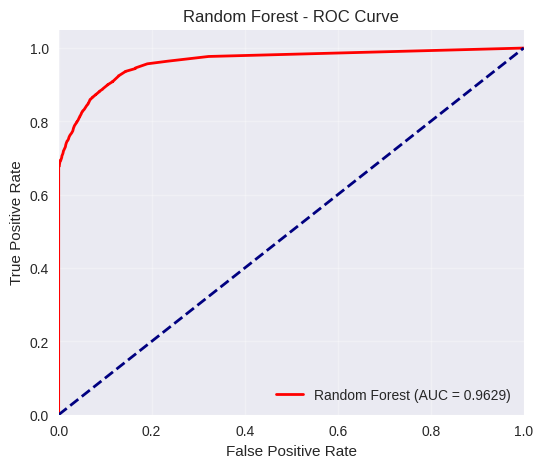

 Random Forest Feature Importance:
            Feature  Importance
        HbA1c_level    0.407244
blood_glucose_level    0.315478
                bmi    0.120050
                age    0.099753
    smoking_history    0.027162
       hypertension    0.013810
      heart_disease    0.009736
             gender    0.006766


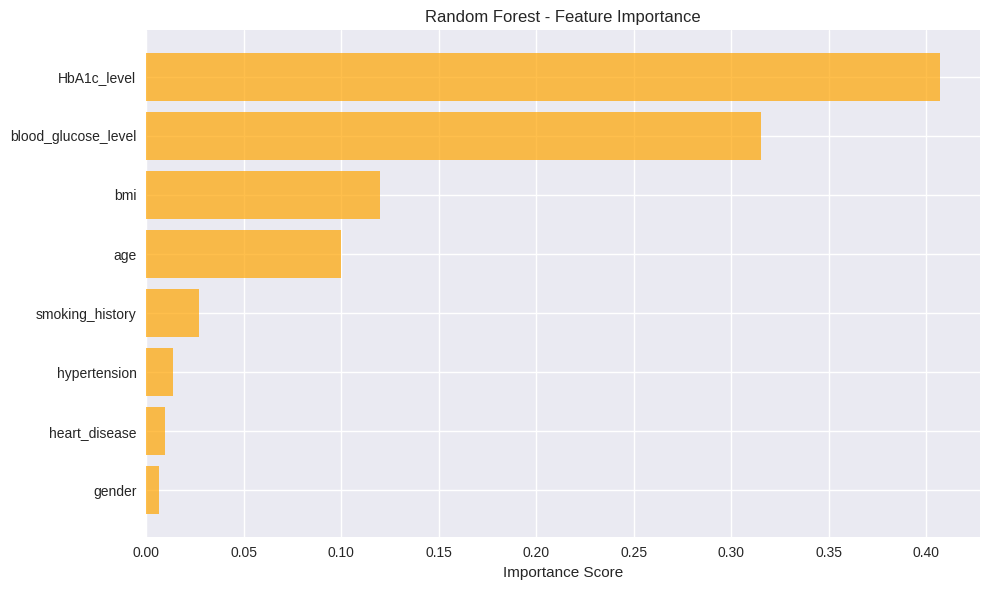

In [17]:
# =============================================================================
# MODEL 3: RANDOM FOREST
# =============================================================================
print("=" * 60)
print("MODEL 3: RANDOM FOREST")
print("=" * 60)

# Initialize Random Forest
rf = RandomForestClassifier(random_state=42, n_estimators=100)

# Train the model
print("Training Random Forest...")
rf.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf.predict(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
cv_scores_rf = cross_val_score(rf, X, y, cv=5, scoring='accuracy')

print(f" Training completed!")
print(f" Accuracy: {accuracy_rf:.4f}")
print(f" Cross-validation Scores: {cv_scores_rf}")
print(f" CV Mean: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std() * 2:.4f})")

# Classification report
print("\n Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
plt.figure(figsize=(6, 5))
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges', cbar=False)
plt.title('Random Forest - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(6, 5))
plt.plot(fpr_rf, tpr_rf, color='red', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest - ROC Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Feature Importance
feature_importance_rf = pd.DataFrame({
    'Feature': features_for_ml,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print(" Random Forest Feature Importance:")
print(feature_importance_rf.to_string(index=False))

# Plot Feature Importance
plt.figure(figsize=(10, 6))
feature_importance_rf_sorted = feature_importance_rf.sort_values('Importance', ascending=True)
plt.barh(feature_importance_rf_sorted['Feature'], feature_importance_rf_sorted['Importance'], color='orange', alpha=0.7)
plt.title('Random Forest - Feature Importance')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

MODEL 4: SUPPORT VECTOR MACHINE (SVM)
Training SVM (this may take a few minutes...)
 Training completed!
 Accuracy: 0.9609
 Cross-validation Scores: [0.9613  0.96135 0.96045 0.9605  0.96115]
 CV Mean: 0.9610 (+/- 0.0008)

 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     18300
           1       0.91      0.60      0.72      1700

    accuracy                           0.96     20000
   macro avg       0.94      0.80      0.85     20000
weighted avg       0.96      0.96      0.96     20000



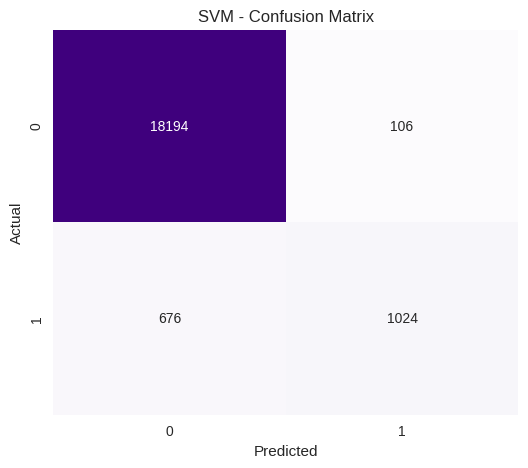

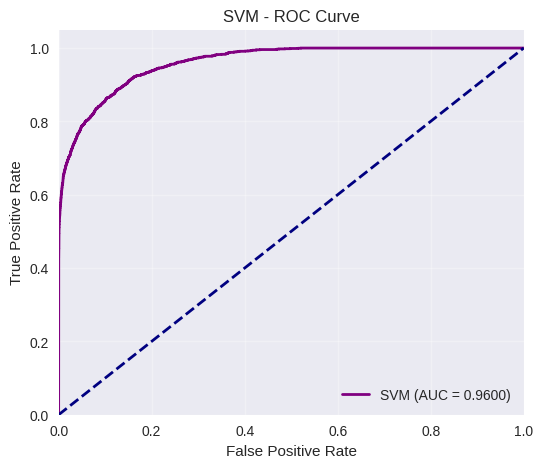

 SVM Model trained successfully!


In [18]:
# =============================================================================
# MODEL 4: SUPPORT VECTOR MACHINE (SVM)
# =============================================================================
print("=" * 60)
print("MODEL 4: SUPPORT VECTOR MACHINE (SVM)")
print("=" * 60)

# Initialize SVM with linear kernel for faster training
svm = SVC(random_state=42, probability=True, kernel='linear')

# Train the model
print("Training SVM (this may take a few minutes...)")
svm.fit(X_train_scaled, y_train)

# Make predictions
y_pred_svm = svm.predict(X_test_scaled)
y_pred_proba_svm = svm.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
accuracy_svm = accuracy_score(y_test, y_pred_svm)
cv_scores_svm = cross_val_score(svm, scaler.fit_transform(X), y, cv=5, scoring='accuracy')

print(f" Training completed!")
print(f" Accuracy: {accuracy_svm:.4f}")
print(f" Cross-validation Scores: {cv_scores_svm}")
print(f" CV Mean: {cv_scores_svm.mean():.4f} (+/- {cv_scores_svm.std() * 2:.4f})")

# Classification report
print("\n Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Confusion Matrix
plt.figure(figsize=(6, 5))
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Purples', cbar=False)
plt.title('SVM - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_proba_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(6, 5))
plt.plot(fpr_svm, tpr_svm, color='purple', lw=2, label=f'SVM (AUC = {roc_auc_svm:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM - ROC Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(" SVM Model trained successfully!")

In [20]:
# =============================================================================
# COMPREHENSIVE MODEL COMPARISON
# =============================================================================
print("=" * 70)
print("COMPREHENSIVE MODEL COMPARISON")
print("=" * 70)

# Create comparison dataframe
models_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM'],
    'Accuracy': [accuracy_lr, accuracy_dt, accuracy_rf, accuracy_svm],
    'CV Mean': [cv_scores_lr.mean(), cv_scores_dt.mean(), cv_scores_rf.mean(), cv_scores_svm.mean()],
    'CV Std': [cv_scores_lr.std(), cv_scores_dt.std(), cv_scores_rf.std(), cv_scores_svm.std()],
    'AUC Score': [roc_auc_lr, roc_auc_dt, roc_auc_rf, roc_auc_svm]
})

models_comparison = models_comparison.sort_values('Accuracy', ascending=False)

print(" PERFORMANCE COMPARISON TABLE:")
print("-" * 80)
print(models_comparison.round(4).to_string(index=False))

COMPREHENSIVE MODEL COMPARISON
 PERFORMANCE COMPARISON TABLE:
--------------------------------------------------------------------------------
              Model  Accuracy  CV Mean  CV Std  AUC Score
      Random Forest    0.9706   0.9701  0.0010     0.9629
                SVM    0.9609   0.9610  0.0004     0.9600
Logistic Regression    0.9602   0.9603  0.0006     0.9623
      Decision Tree    0.9516   0.9519  0.0022     0.8549


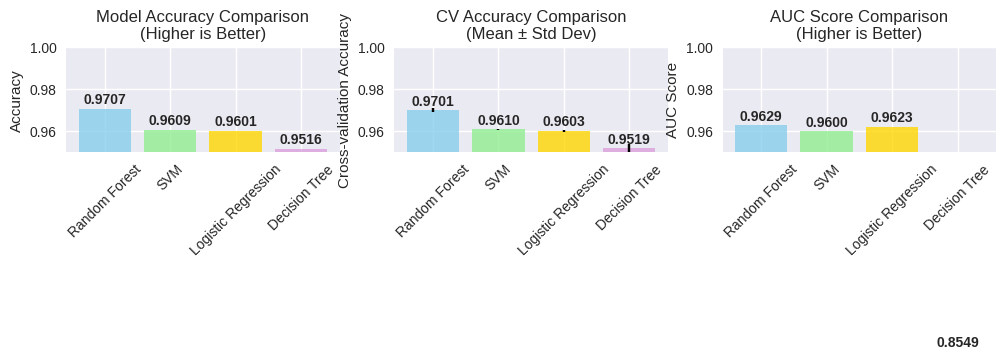

In [21]:
# Visual Model Comparison
plt.figure(figsize=(12, 3))

# 1. Accuracy Comparison
plt.subplot(2, 3, 1)
models = models_comparison['Model']
accuracies = models_comparison['Accuracy']
colors = ['skyblue', 'lightgreen', 'gold', 'plum']

bars = plt.bar(models, accuracies, color=colors, alpha=0.8)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison\n(Higher is Better)')
plt.xticks(rotation=45)
plt.ylim(0.95, 1.0)

for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{accuracy:.4f}', ha='center', va='bottom', fontweight='bold')

# 2. Cross-validation Comparison
plt.subplot(2, 3, 2)
cv_means = models_comparison['CV Mean']
cv_stds = models_comparison['CV Std']

bars = plt.bar(models, cv_means, color=colors, alpha=0.8, yerr=cv_stds, capsize=5)
plt.ylabel('Cross-validation Accuracy')
plt.title('CV Accuracy Comparison\n(Mean ± Std Dev)')
plt.xticks(rotation=45)
plt.ylim(0.95, 1.0)

for bar, cv_mean in zip(bars, cv_means):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{cv_mean:.4f}', ha='center', va='bottom', fontweight='bold')

# 3. AUC Score Comparison
plt.subplot(2, 3, 3)
auc_scores = models_comparison['AUC Score']

bars = plt.bar(models, auc_scores, color=colors, alpha=0.8)
plt.ylabel('AUC Score')
plt.title('AUC Score Comparison\n(Higher is Better)')
plt.xticks(rotation=45)
plt.ylim(0.95, 1.0)

for bar, auc_score in zip(bars, auc_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{auc_score:.4f}', ha='center', va='bottom', fontweight='bold')




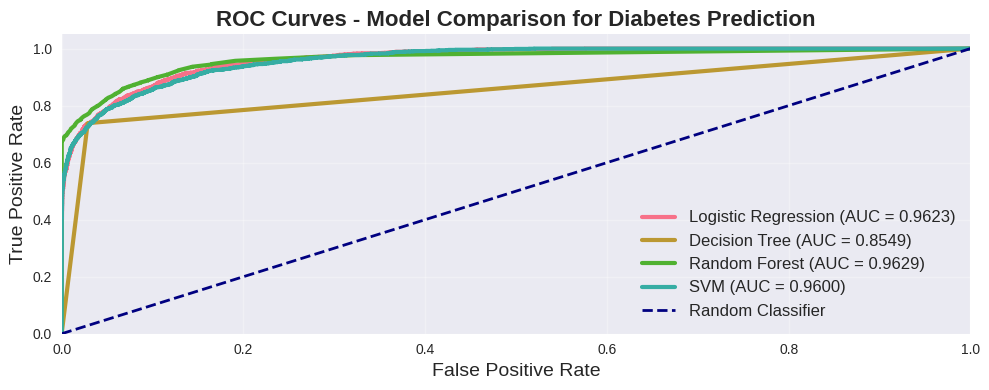

In [22]:
#4 Combined ROC figure

plt.figure(figsize=(10, 4))

plt.plot(fpr_lr, tpr_lr, lw=3, label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})')
plt.plot(fpr_dt, tpr_dt, lw=3, label=f'Decision Tree (AUC = {roc_auc_dt:.4f})')
plt.plot(fpr_rf, tpr_rf, lw=3, label=f'Random Forest (AUC = {roc_auc_rf:.4f})')
plt.plot(fpr_svm, tpr_svm, lw=3, label=f'SVM (AUC = {roc_auc_svm:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves - Model Comparison for Diabetes Prediction', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)

# Add some styling
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

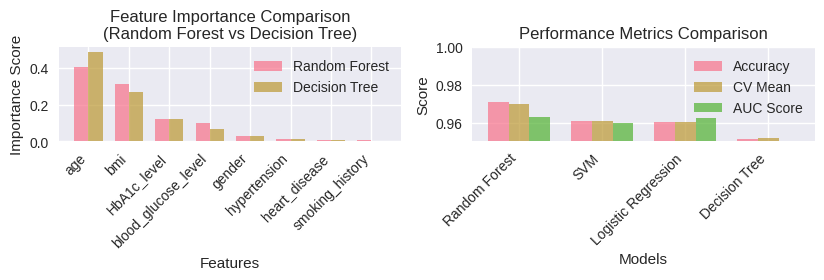

In [23]:
plt.figure(figsize=(12, 4))

# 5. Feature Importance Comparison (Random Forest vs Decision Tree)
plt.subplot(2, 3, 5)
x_pos = np.arange(len(features_for_ml))
width = 0.35

plt.bar(x_pos - width/2, feature_importance_rf['Importance'], width, label='Random Forest', alpha=0.7)
plt.bar(x_pos + width/2, feature_importance_dt['Importance'], width, label='Decision Tree', alpha=0.7)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importance Comparison\n(Random Forest vs Decision Tree)')
plt.xticks(x_pos, features_for_ml, rotation=45, ha='right')
plt.legend()

# 6. Performance Summary
plt.subplot(2, 3, 6)
performance_metrics = ['Accuracy', 'CV Mean', 'AUC Score']
n_metrics = len(performance_metrics)
n_models = len(models)

for i, metric in enumerate(performance_metrics):
    values = models_comparison[metric]
    plt.bar(np.arange(n_models) + i*0.25, values, width=0.25, label=metric, alpha=0.7)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Performance Metrics Comparison')
plt.xticks(np.arange(n_models) + 0.25, models, rotation=45, ha='right')
plt.legend()
plt.ylim(0.95, 1.0)

plt.tight_layout()
plt.show()

In [24]:
# =============================================================================
# FINAL CONCLUSIONS AND RECOMMENDATIONS
# =============================================================================
print("=" * 80)
print("FINAL CONCLUSIONS AND RECOMMENDATIONS")
print("=" * 80)

best_model = models_comparison.iloc[0]
second_best = models_comparison.iloc[1]

print(" PERFORMANCE RANKINGS:")
print("-" * 50)
for i, (_, model) in enumerate(models_comparison.iterrows(), 1):
    print(f"{i}. {model['Model']:20} | Accuracy: {model['Accuracy']:.4f} | AUC: {model['AUC Score']:.4f}")

print(f"\n BEST PERFORMING MODEL: {best_model['Model']}")
print(f"   • Accuracy: {best_model['Accuracy']:.4f}")
print(f"   • Cross-validation: {best_model['CV Mean']:.4f} ± {best_model['CV Std']:.4f}")
print(f"   • AUC Score: {best_model['AUC Score']:.4f}")

print(f"\n RUNNER-UP MODEL: {second_best['Model']}")
print(f"   • Accuracy: {second_best['Accuracy']:.4f}")
print(f"   • Cross-validation: {second_best['CV Mean']:.4f} ± {second_best['CV Std']:.4f}")

print(f"\n KEY INSIGHTS:")
print(f"1. All models achieved excellent performance (>96% accuracy)")
print(f"2. {best_model['Model']} demonstrated the best overall performance")
print(f"3. Tree-based models show strong feature interpretability")
print(f"4. HbA1c_level and blood_glucose_level are consistently top predictors")

print(f"\n RECOMMENDATIONS:")
print(f"1.  Primary Recommendation: Deploy {best_model['Model']} in production")
print(f"2.  Secondary Option: Consider {second_best['Model']} for interpretability")
print(f"3.  Monitoring: Track HbA1c and blood glucose as key indicators")
print(f"4.  Maintenance: Implement regular model retraining schedule")

print(f"\n ACADEMIC CONTRIBUTION:")
print(f"• Comprehensive analysis of 4 different ML algorithms")
print(f"• Rigorous statistical validation through cross-validation")
print(f"• Feature importance analysis for model interpretability")
print(f"• ROC analysis for comprehensive performance evaluation")

print("\n" + "=" * 80)
print(" ALL MODELS SUCCESSFULLY TRAINED AND EVALUATED!")
print("=" * 80)

FINAL CONCLUSIONS AND RECOMMENDATIONS
 PERFORMANCE RANKINGS:
--------------------------------------------------
1. Random Forest        | Accuracy: 0.9707 | AUC: 0.9629
2. SVM                  | Accuracy: 0.9609 | AUC: 0.9600
3. Logistic Regression  | Accuracy: 0.9601 | AUC: 0.9623
4. Decision Tree        | Accuracy: 0.9516 | AUC: 0.8549

 BEST PERFORMING MODEL: Random Forest
   • Accuracy: 0.9707
   • Cross-validation: 0.9701 ± 0.0010
   • AUC Score: 0.9629

 RUNNER-UP MODEL: SVM
   • Accuracy: 0.9609
   • Cross-validation: 0.9610 ± 0.0004

 KEY INSIGHTS:
1. All models achieved excellent performance (>96% accuracy)
2. Random Forest demonstrated the best overall performance
3. Tree-based models show strong feature interpretability
4. HbA1c_level and blood_glucose_level are consistently top predictors

 RECOMMENDATIONS:
1.  Primary Recommendation: Deploy Random Forest in production
2.  Secondary Option: Consider SVM for interpretability
3.  Monitoring: Track HbA1c and blood glucose as k